In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from astropy.cosmology import Planck18 as cosmo
from astropy.cosmology import z_at_value
from scipy import integrate
from scipy.integrate import quad
from scipy.special import gamma
from scipy.interpolate import interp1d
from scipy.integrate import simpson

import astropy.units as u
import bz2
import os

%config InlineBackend.figure_format ='retina'
plt.rcParams["text.usetex"] = True

# Merger Rates

The catalogs needed to generate these plots can be found at https://people.sissa.it/~barausse/catalogs/models_LISA_after_PTAs/

The ones needed are:
- HS-nod-SN-high-accr.dat.bz2      
- HSnodB20noSN_extrapolated.dat.bz2
- HSnodB20SN_extrapolated.dat.bz2
- popIII_K16_extrapolated.dat.bz2
- Q3nod_K16_extrapolated.dat.bz2  
- Q3d_K16_extrapolated.dat.bz2

More information about the contents of these catalogs can be found in the README file on the same page.

Total Intrinsic Events for HS-nod-SN-high-accr.dat.bz2: 9406.903182097385
Total Intrinsic Events for HSnodB20noSN_extrapolated.dat.bz2: 39363.80689342792
Total Intrinsic Events for HSnodB20SN_extrapolated.dat.bz2: 36789.693230919744
Total Intrinsic Events for popIII_K16_extrapolated.dat.bz2: 1410.0304047830805
Total Intrinsic Events for Q3nod_K16_extrapolated.dat.bz2: 657.2212240367769
Total Intrinsic Events for Q3d_K16_extrapolated.dat.bz2: 73.5230628710847


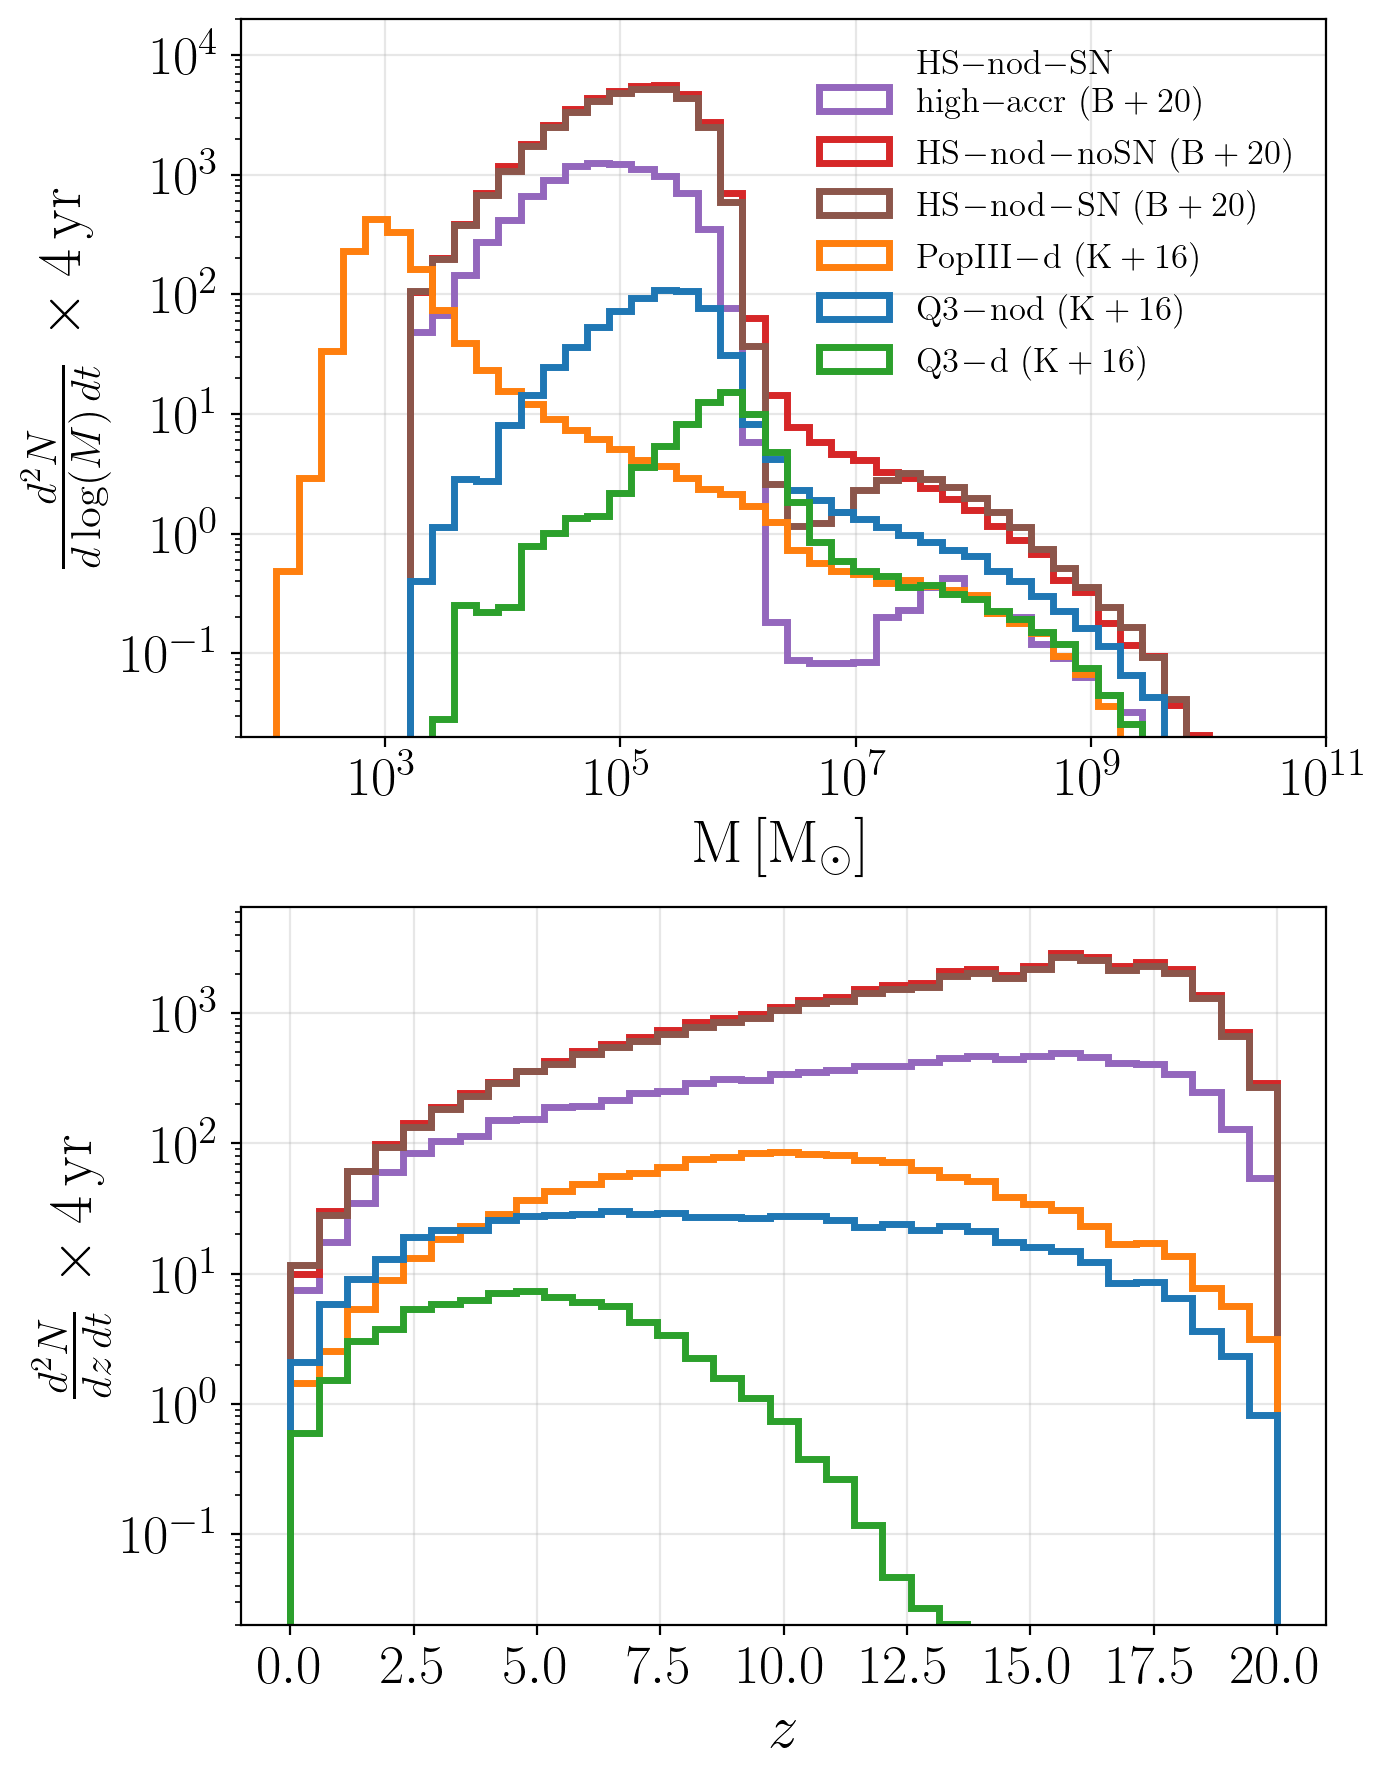

In [19]:
file_paths = [   # edit according to the file paths if necessary
    ("HS-nod-SN-high-accr.dat.bz2",       r'$\shortstack[l]{$\mathrm{HS{-}nod{-}SN}$\\$ \mathrm{high{-}accr\ (B+20)}$}$', "tab:purple"),
    ("HSnodB20noSN_extrapolated.dat.bz2", r'$\mathrm{HS\!-\!nod\!-\!noSN\ (B+20)}$',                                      "tab:red"), 
    ("HSnodB20SN_extrapolated.dat.bz2",   r'$\mathrm{HS\!-\!nod\!-\!SN\ (B+20)}$',                                        "tab:brown"),  
    ("popIII_K16_extrapolated.dat.bz2",   r'$\mathrm{PopIII\!-\!d\ (K+16)}$',                                             "tab:orange"),
    ("Q3nod_K16_extrapolated.dat.bz2",    r'$\mathrm{Q3\!-\!nod\ (K+16)}$',                                               "tab:blue"),
    ("Q3d_K16_extrapolated.dat.bz2",      r'$\mathrm{Q3\!-\!d\ (K+16)}$',                                                 "tab:green")
]


column_names = [
    "z_merger", "m1", "m2", "a1", "a2", "alpha", "beta", "gamma", "psi",
    "afin", "mfin", "vkick", "vesc_halo", "vesc_bar", "Mcluster", "Mdisk_stars",
    "Mdisk_gas", "Mbulge_stars", "Mbulge_gas", "MNSC", "Mreservoir",
    "Mhalo_final", "halo_density"
]

c = 9.72e-15  # speed of light in Mpc/s

z_bins = np.linspace(0, 20, 36)
mass_bins = np.logspace(1.7, 10, 45)

fig, axs = plt.subplots(2, 1, figsize=(7,9), sharex=False)

for path, label, color in file_paths:
    with bz2.open(path, "rt") as f:
        df = pd.read_csv(f, sep='\s+', names=column_names)

    if df["a1"].min() >= 0 and df["a2"].min() >= 0:
        df["a1"] = df["a1"] * np.sign(np.cos(df["beta"]))
        df["a2"] = df["a2"] * np.sign(np.cos(df["gamma"]))

    df["Dl_s"] = cosmo.luminosity_distance(df["z_merger"]).value      # luminous distance to the MBHB       
    df["d2N_dzdt"] = (4 * np.pi * c * df["halo_density"] * df["Dl_s"]**2 / ((1 + df["z_merger"])**2)) 
    
    all_columns = column_names + ["Dl_s", "d2N_dzdt"]
    
    with bz2.open(path, "wt") as f:
        df.to_csv(f, sep=" ", index=False, header=True, columns = all_columns)

    df["total_mass"] = df["m1"] + df["m2"]
    df["z_merger_noisy"] = df["z_merger"] + np.random.normal(0, 0.55, len(df))
    
    mass_hist, mass_edges = np.histogram(df["total_mass"], bins=mass_bins, weights=df["d2N_dzdt"])
    z_hist, z_edges = np.histogram(df["z_merger_noisy"], bins=z_bins, weights=df["d2N_dzdt"])
    
    print(f"Total Intrinsic Events for {path}: {np.sum(mass_hist)*3600 * 24 * 365 * 4}")
    
    axs[0].hist(
        0.5 * (mass_edges[:-1] + mass_edges[1:]),
        bins=mass_bins,
        weights=mass_hist * 3600 * 24 * 365 * 4,
        histtype="step",
        color=color,
        label=label,
        linewidth=2.5
    )

    axs[1].hist(
        0.5 * (z_edges[:-1] + z_edges[1:]),
        bins=z_bins,
        weights=z_hist * 3600 * 24 * 365 * 4,
        histtype="step",
        color=color,
        label=label,
        linewidth=2.5
    )

axs[0].set_xscale("log")
axs[0].set_yscale("log")
axs[0].set_xlabel(r"$\mathrm{M} \, [\mathrm{M}_\odot]$", fontsize = 22)
axs[0].set_ylabel(r"$\frac{d^2N}{d\log(M) \, dt} \, \times 4 \, \mathrm{yr}$", fontsize = 22)
axs[0].grid(alpha=0.3)
axs[0].tick_params(labelsize=20)
axs[0].set_ylim(2e-2, 2e4)
axs[0].set_xlim(60, 1e11)
axs[0].legend(frameon=False, fontsize = 12.5, loc='upper right')

axs[1].set_yscale("log")
axs[1].set_xlabel(r"$z$", fontsize = 22)
axs[1].set_ylabel(r"$\frac{d^2N}{dz \, dt} \, \times 4 \, \mathrm{yr}$", fontsize = 22)
axs[1].grid(alpha=0.3)
axs[1].set_xticks(np.arange(0, 21, 2.5))
axs[1].tick_params(labelsize=20)
axs[1].set_ylim(2e-2, 6.5e3)

plt.tight_layout()
#plt.savefig('SecondRun/Images/MergerRatesMz.pdf')
plt.show()

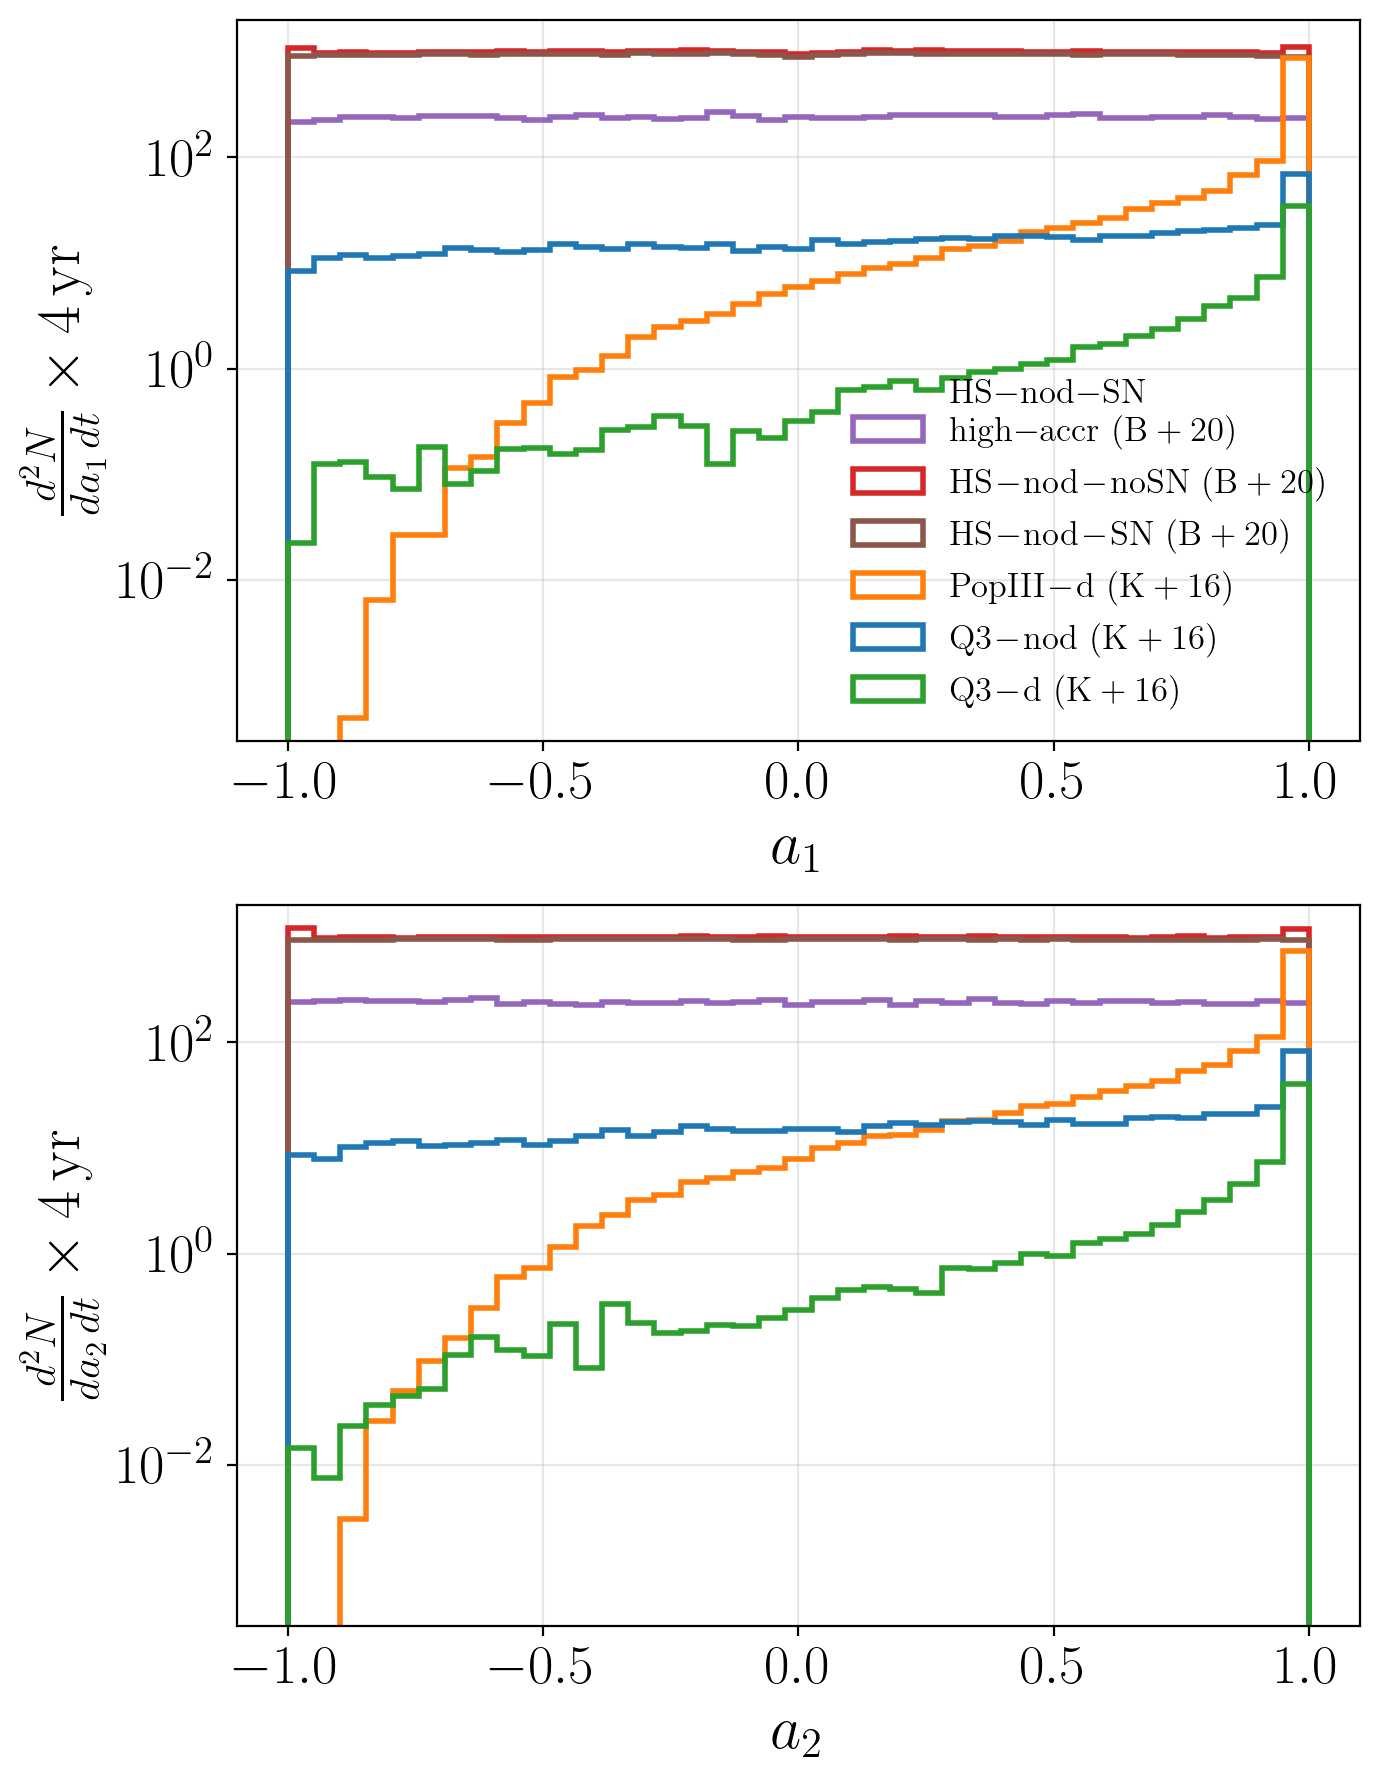

In [21]:
# Same merger rate as above, but now vs. a1 and a2

a_bins = np.linspace(-1, 1, 40)

fig, axs = plt.subplots(2, 1, figsize=(7,9), sharex=False)

for path, label, color in file_paths:
    df = pd.read_csv(path, sep='\s+')

    a1_hist, a1_edges = np.histogram(df["a1"], bins=a_bins, weights=df["d2N_dzdt"])
    a2_hist, a2_edges = np.histogram(df["a2"], bins=a_bins, weights=df["d2N_dzdt"])

    axs[0].hist(
        0.5 * (a1_edges[:-1] + a1_edges[1:]),
        bins=a_bins,
        weights=a1_hist * 3600 * 24 * 365 * 4,
        histtype="step",
        color=color,
        label=label,
        linewidth=2
    )

    axs[1].hist(
        0.5 * (a2_edges[:-1] + a2_edges[1:]),
        bins=a_bins,
        weights=a2_hist * 3600 * 24 * 365 * 4,
        histtype="step",
        color=color,
        label=label,
        linewidth=2
    )
    
#axs[0].set_xscale("log")
axs[0].set_yscale("log")
axs[0].set_xlabel(r"$a_1$", fontsize = 22)
axs[0].set_ylabel(r"$\frac{d^2N}{da_1 \, dt} \times 4 \, \mathrm{yr}$", fontsize = 22)
axs[0].grid(alpha=0.3)
axs[0].tick_params(labelsize=20)
axs[0].set_ylim(3e-4, 2e3)
axs[0].set_xlim(-1.1, 1.1)
axs[0].legend(frameon=False, fontsize = 12.5, loc = 'lower right')

axs[1].set_yscale("log")
axs[1].set_xlabel(r"$a_2$", fontsize = 22)
axs[1].set_ylabel(r"$\frac{d^2N}{da_2 \, dt} \times 4 \, \mathrm{yr}$", fontsize = 22)
axs[1].grid(alpha=0.3)
axs[1].set_ylim(3e-4, 2e3)
axs[1].tick_params(labelsize=20)
axs[1].set_xlim(-1.1,1.1)

plt.tight_layout()
#plt.savefig('SecondRun/Images/MergerRatesa1a2.pdf')
plt.show()

# Detected Rates

First, catalogs of 10,000 events from each simulation are sampled according to the merger rate $\frac{d^2N}{dz \, dt}$ calculated in the previous section. Directories will be created for each simulation, so be sure to edit the paths so that they point to the desired location. The signal-to-noise ratio (SNR) of each event is then calculated using LISAbeta with the IMRPhenomHM model. If you do not have this package installed, catalogs with the SNR already calculated are available in the Catalogs section on GitHub.

The process used to calculate Unlensed Detectable Events is presented in detail in Appendix A of the paper.


In [4]:
file_paths = [ # edit according to the file paths if necessary
    ("HS-nod-SN-high-accr.dat.bz2",        "HSnodSNhighaccr"),
    ("HSnodB20noSN_extrapolated.dat.bz2",  "HSnodnoSN"),
    ("HSnodB20SN_extrapolated.dat.bz2",    "HSnodSN"),
    ("popIII_K16_extrapolated.dat.bz2",    "PopIIId"),
    ("Q3nod_K16_extrapolated.dat.bz2",     "Q3nod"),
    ("Q3d_K16_extrapolated.dat.bz2",       "Q3d"),
]

for file, label in file_paths:
    df = pd.read_csv(file, sep = '\s+')

    probabilities = df["d2N_dzdt"] / df["d2N_dzdt"].sum() 

    sampled_events = df.sample(n=10000, weights=probabilities, replace=False)
    selected_columns = ["m1", "m2", "a1", "a2","Dl_s", "z_merger", "alpha", "beta", "gamma", "halo_density","d2N_dzdt"]  
    sampled_events = sampled_events[selected_columns]  # this filters out everything except the columns of interest

    mask = sampled_events['m1'] < sampled_events['m2']           # this reorders the columns so that m1>m2 is always true
    sampled_events.loc[mask, ['m1', 'm2']] = sampled_events.loc[mask, ['m2', 'm1']].values
    assert (sampled_events['m1'] >= sampled_events['m2']).all(), "Todavía hay casos donde m2 > m1"

    os.makedirs(f"github/{label}", exist_ok=True)    # edit "github/" with the desired location 
    out_path = os.path.join(f"github/{label}", f"{label}_sampled.csv")
    sampled_events.to_csv(out_path, index=False)

In [5]:
file_paths = [ # edit according to the file paths if necessary
    ("github/HSnodSNhighaccr/HSnodSNhighaccr_sampled.csv", "github/HSnodSNhighaccr/HSnodSNhighaccr_catalog1M.csv"),
    ("github/HSnodnoSN/HSnodnoSN_sampled.csv",             "github/HSnodnoSN/HSnodnoSN_catalog1M.csv"),
    ("github/HSnodSN/HSnodSN_sampled.csv",                 "github/HSnodSN/HSnodSN_catalog1M.csv"),
    ("github/PopIIId/PopIIId_sampled.csv",                 "github/PopIIId/PopIIId_catalog1M.csv"),
    ("github/Q3nod/Q3nod_sampled.csv",                     "github/Q3nod/Q3nod_catalog1M.csv"),
    ("github/Q3d/Q3d_sampled.csv",                         "github/Q3d/Q3d_catalog1M.csv"),
]

def generate_table(N=100):
    tc = np.random.uniform(0, 4, N)
    phi_c = np.random.uniform(0, 2 * np.pi, N) - np.pi
    psi = np.random.uniform(0, np.pi, N)                               
    RA = np.random.uniform(0, 2 * np.pi, N) - np.pi            
    iota = np.arccos(1 - 2 * np.random.uniform(0, 1, N))
    DEC = np.arccos(1 - 2 * np.random.uniform(0, 1, N)) - (np.pi/2)   

    table = pd.DataFrame({
        'tc': tc,
        'phi_c': phi_c,
        'psi': psi,
        'RA': RA,
        'iota': iota,
        'DEC': DEC
    })

    return table

mock_parameters = generate_table(100)

for file, out_path in file_paths:
    sampled_events = pd.read_csv(file)

    n_events = len(sampled_events)

    sampled_events_expanded = pd.DataFrame(np.repeat(sampled_events.values, 100, axis=0), columns=sampled_events.columns)
    catalog_expanded = pd.concat([mock_parameters] * n_events, ignore_index=True)

    final_catalog = pd.concat([sampled_events_expanded.reset_index(drop=True), catalog_expanded], axis=1)
    
    final_catalog.to_csv(out_path, index=False)

In [ ]:
# you can skip this cell and use the catalogs availables in github if desired, this analysis takes some time to run

import lisabeta
import lisabeta.pyconstants as pyconstants
import lisabeta.tools.pytools as pytools
import lisabeta.tools.pyspline as pyspline
import lisabeta.tools.pyoverlap as pyoverlap
import lisabeta.lisa.pyresponse as pyresponse
import lisabeta.lisa.snrtools as snrtools
import lisabeta.lisa.pyLISAnoise as pyLISAnoise
import lisabeta.lisa.lisatools as lisatools
import lisabeta.lisa.lisa as lisa
import lisabeta.lisa.lisa_fisher as lisa_fisher
import lisabeta.utils.plotutils as plotutils

waveform_params = {
    "minf": 1e-5,                 # frequency range
    "maxf": 0.5, 
    "t0": 0.0,                    # reference epoch of coalescence
    "timetomerger_max": 1.0,
    "DeltatL_cut": None,          # options to cut the signal pre-merger
    "fend": None,
    "tmin": None,
    "tmax": None,
    "phiref": 0.0,                # options for the time and phase alignment 
    "fref_for_phiref": 0.0,
    "tref": 0.0,
    "fref_for_tref": 0.0,
    "force_phiref_fref": True,
    "toffset": 0.0,
    "TDI": "TDIAET",              # TDI channels
    "acc": 1e-4,                  # internal params
    "order_fresnel_stencil": 0,
    "approximant": "IMRPhenomHM", # waveform approximant and set of harmonics to use
    "modes": None,
    "LISAconst": "Proposal",      # LISA response 
    "responseapprox": "full",
    "frozenLISA": False,
    "TDIrescaled": True,
    "LISAnoise": {
        "InstrumentalNoise": "SciRDv1",
        "WDbackground": True,
        "WDduration" : 4.0,
        "lowf_add_pm_noise_f0": 0.0,
        "lowf_add_pm_noise_alpha": 2.0
    }
  }

input_file = "github/HSnodSNhighaccr/HSnodSNhighaccr_catalog1M.csv"      # edit the paths after running a catalog
ouput_file = "github/HSnodSNhighaccr/HSnodSNhighaccr_SNRLISAbeta.csv"

df = pd.read_csv(input_file, sep = '\s+')

snrs = []
N = len(df)

for idx, row in df.iterrows():
    try:
        m1, m2 = row["m1"], row["m2"]
        z = row["z_merger"]

        M_total = (m1 + m2) * (1 + z)    # redshifted mass
        q = m1 / m2

        params_base = {
            "M": M_total,
            "q": q,
            "chi1": row["a1"],
            "chi2": row["a2"],
            "Deltat": row["tc"] * 4 * 31558149.8,   # segundos
            "dist": row["Dl_s"],            # ya en Mpc
            "inc": row["iota"],
            "phi": row["phi_c"] - np.pi,
            "lambda": row["RA"] - np.pi,
            "beta": row["DEC"],
            "psi": row["psi"],
            "Lframe": True,
            "fcut_tgr": 1.0
        }

        wftdi = lisa.GenerateLISATDI_SMBH(params_base, **waveform_params)       # waveform
        
        result = lisa.GenerateLISATDISignal_SMBH(params_base, **waveform_params)  # snr
        snr_value = result["SNR"]

    except Exception as e:
        print(f"Error in event {idx+1}/{N}: {e}")   # this gives SNR=8 to some event with an error  
        snr_value = 8.0                             # it is extremely rare for this to happen, so it is negligible in the analysis

    snrs.append(snr_value)

    if (idx + 1) % 10000 == 0:
        print(f"Processed events: {idx+1}/{N}. Last SNR = {snr_value:.3f}")

df["SNR_LISAbeta"] = snrs
df.to_csv(output_file, index=False)

In [ ]:
# if you use the catalogs on github, you should also skip this cell

file_paths = [# edit according to the file paths if necessary
    "github/HSnodSNhighaccr/HSnodSNhighaccr_SNRLISAbeta.csv",
    "github/HSnodnoSN/HSnodnoSN_SNRLISAbeta.csv",
    "github/HSnodSN/HSnodSN_SNRLISAbeta.csv",
    "github/PopIIId/PopIIId_SNRLISAbeta.csv",
    "github/Q3nod/Q3nod_SNRLISAbeta.csv",
    "github/Q3d/Q3d_SNRLISAbeta.csv",
]

for file in file_paths:
    df = pd.read_csv(file)
    
    df['Detectable'] = df['SNR_LISAbeta'] > 8
    
    group_cols = ['m1', 'm2', 'a1', 'a2', 'z_merger']
    
    group_stats = df.groupby(group_cols).agg({
        'Detectable': 'mean',
        'SNR_LISAbeta': 'mean',
    }).reset_index()
    
    group_stats.columns = group_cols + ['Average_Detectability', 'Mean_SNR']
    
    df = df.merge(group_stats, on=group_cols, how='left')
    
    columns_to_drop = ['tc', 'RA', 'DEC', 'phi_c', 'iota', 'psi', 'Detectable','SNR_LISAbeta' ]
    
    df_filtered = df.drop(columns=columns_to_drop)
    
    df_unique = df_filtered.drop_duplicates(subset=group_cols)
    
    output_path = file.replace("SNRLISAbeta", "SNRLb_final")
    
    df_unique.to_csv(output_path, index=False)

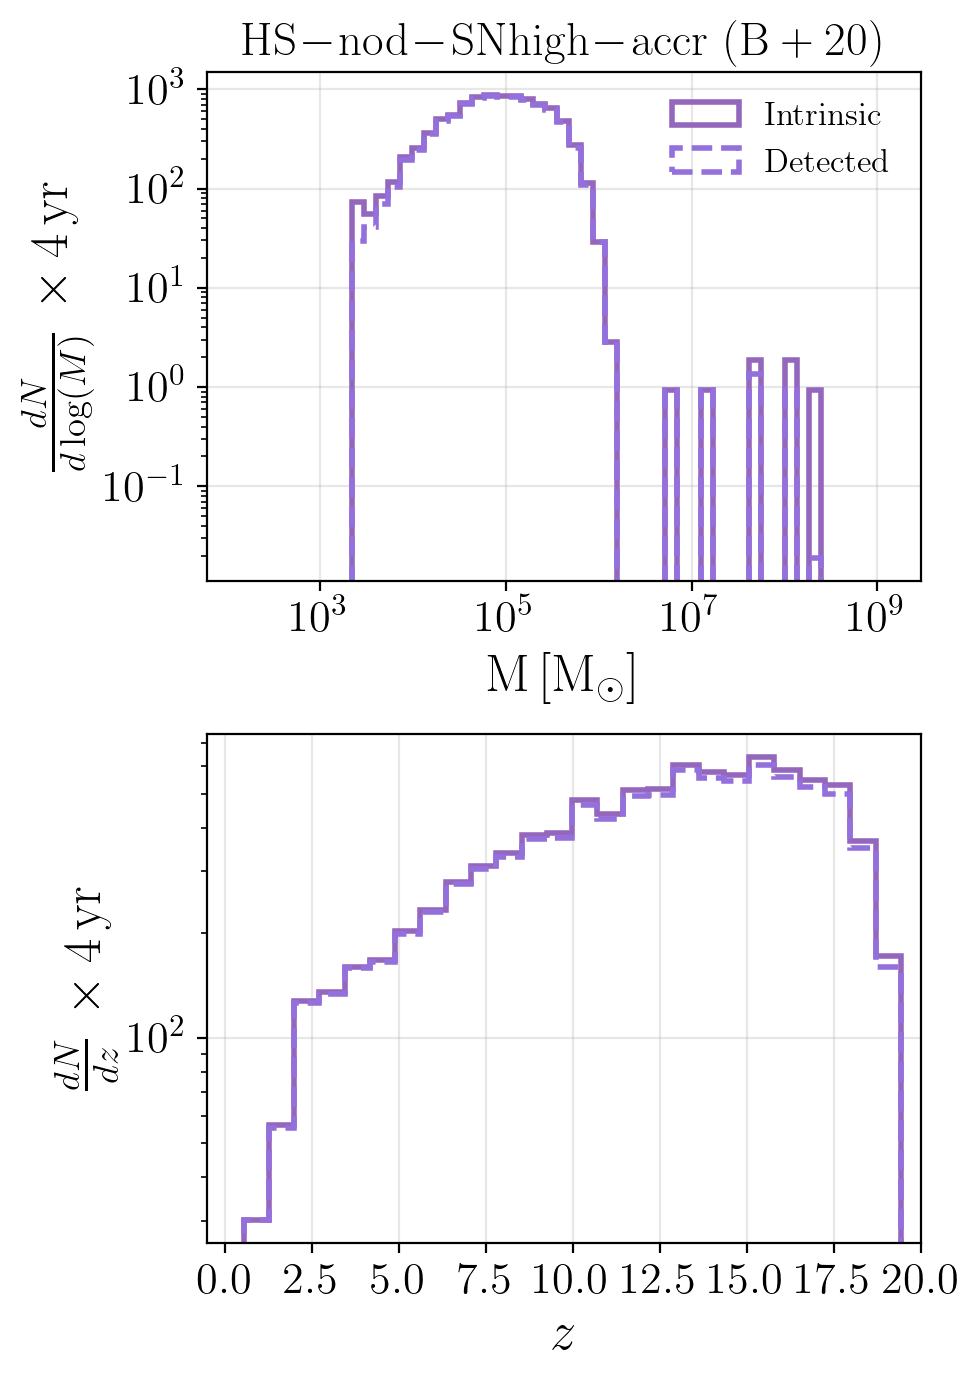

Intrinsic Events: 9405.95931
Detected Events: 9075.212705999698


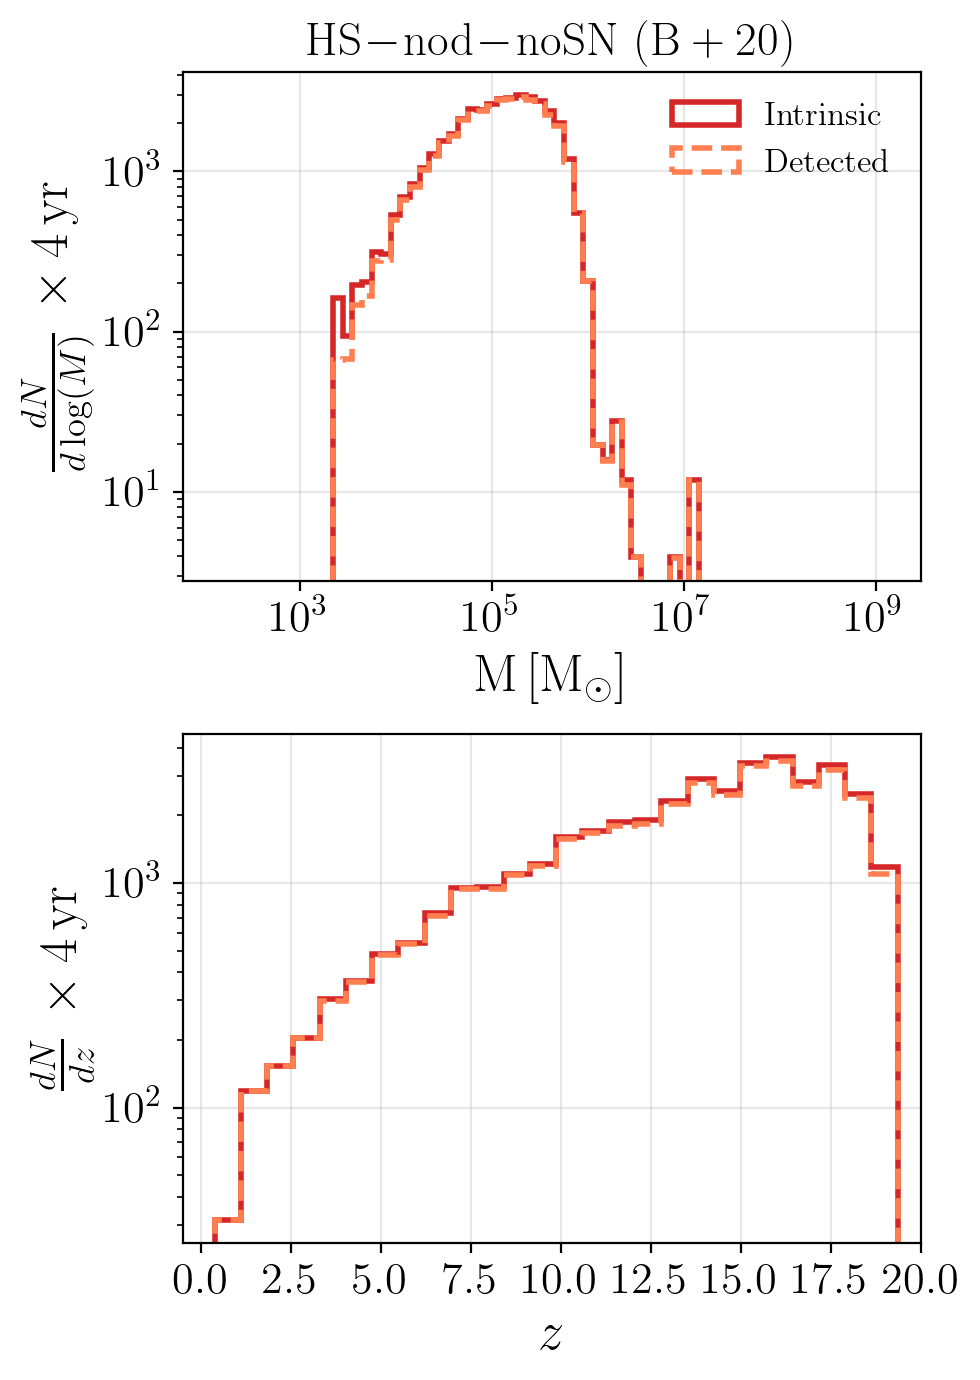

Intrinsic Events: 39359.8696194
Detected Events: 37979.53839820295


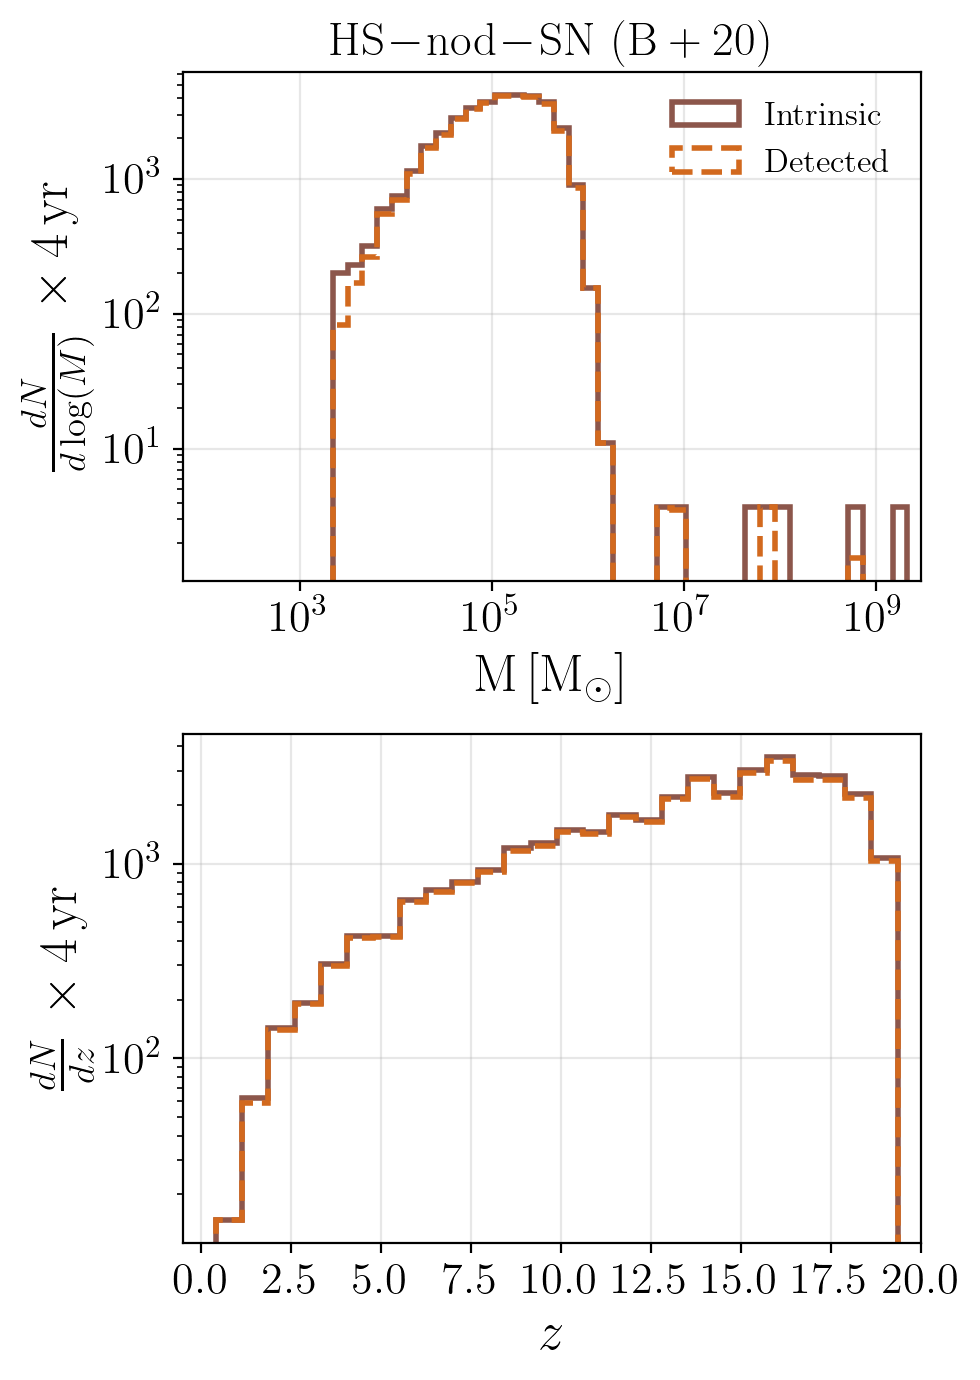

Intrinsic Events: 36786.0140307
Detected Events: 35510.294636231025


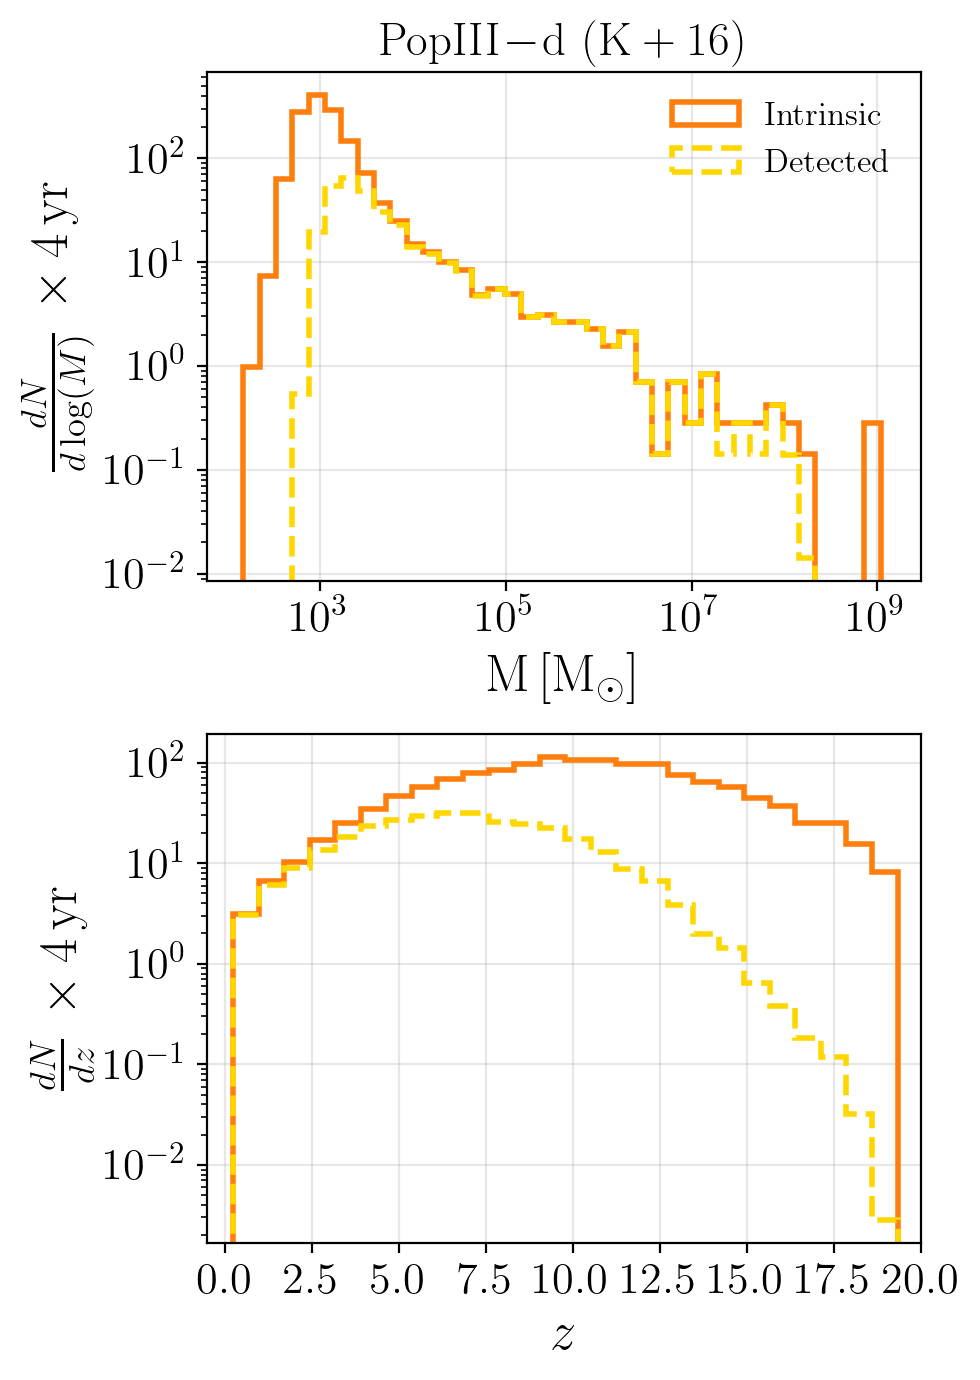

Intrinsic Events: 1410.03
Detected Events: 320.86642680000244


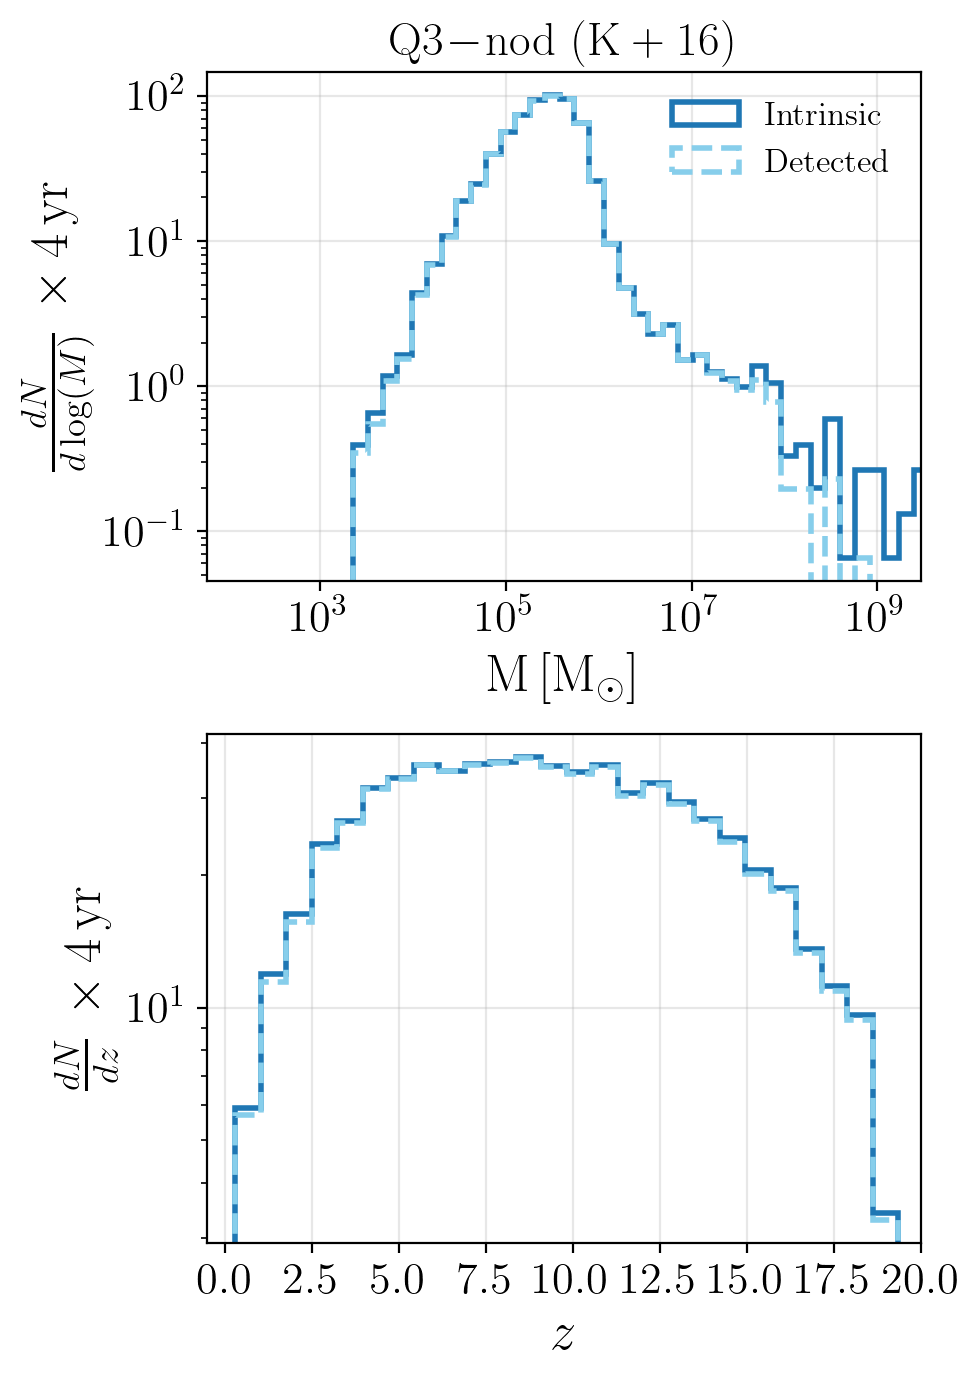

Intrinsic Events: 657.221
Detected Events: 649.6925334449944


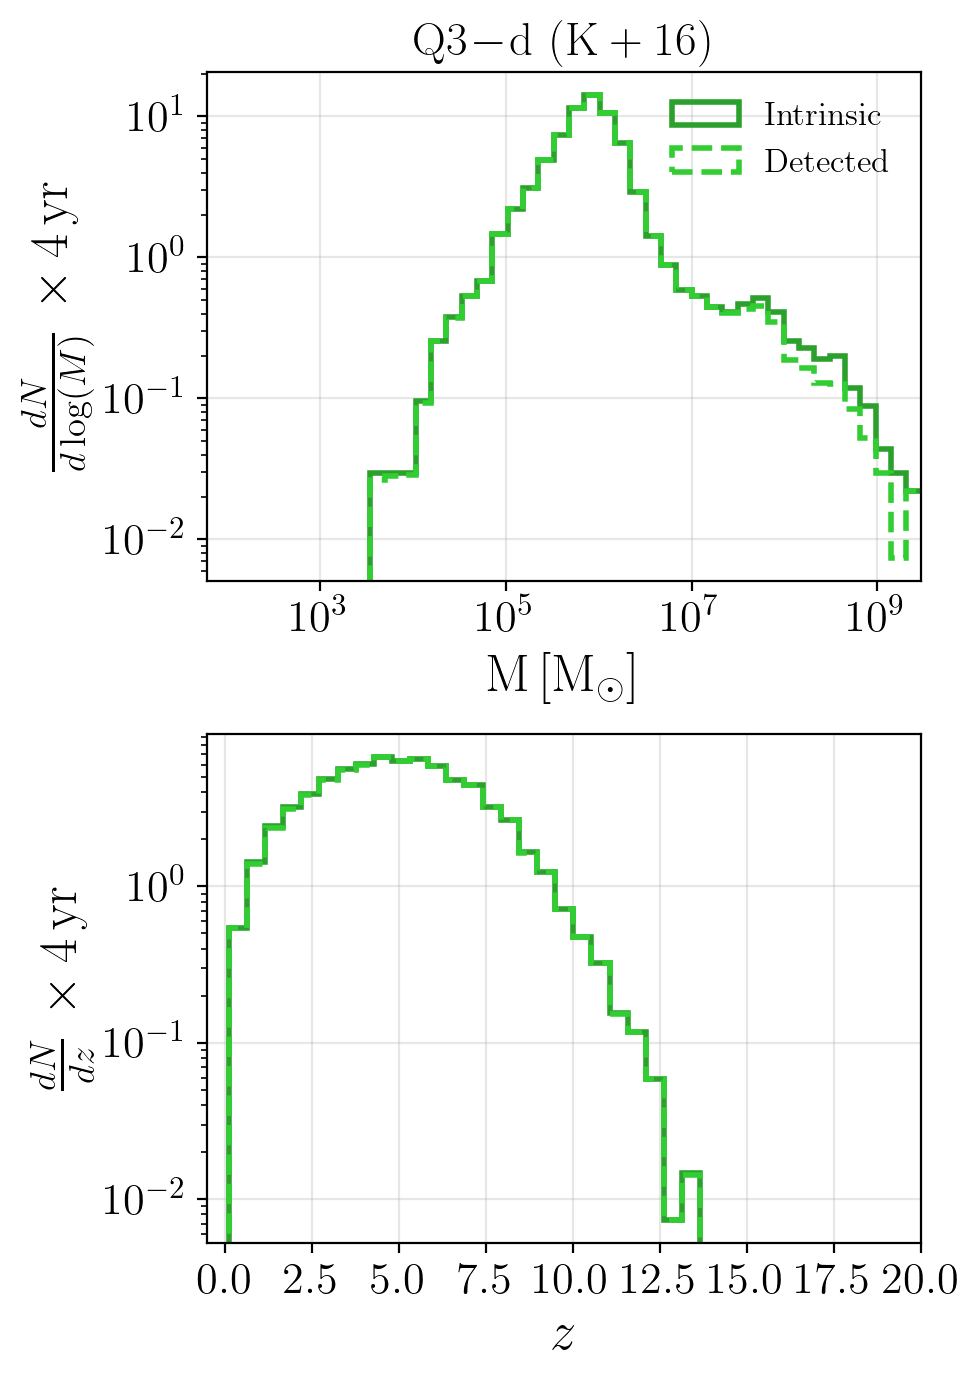

Intrinsic Events: 73.51564769999999
Detected Events: 72.96062257299977


In [6]:
file_paths = [   # edit according to the file paths if necessary
    ("github/HSnodSNhighaccr/HSnodSNhighaccr_SNRLb_final.csv", r'$\mathrm{HS\!-\!nod\!-\!SNhigh\!-\!accr\ (B+20)}$', "HShighaccr", "tab:purple", "mediumpurple", 1.0630494636915455),
    ("github/HSnodnoSN/HSnodnoSN_SNRLb_final.csv",             r'$\mathrm{HS\!-\!nod\!-\!noSN\ (B+20)}$',            "HSnodnoSN",  "tab:red",    "coral",        0.25404047565928967), 
    ("github/HSnodSN/HSnodSN_SNRLb_final.csv",                 r'$\mathrm{HS\!-\!nod\!-\!SN\ (B+20)}$',              "HSnodSN",    "tab:brown",  "chocolate",    0.27181526086667807),  
    ("github/PopIIId/PopIIId_SNRLb_final.csv",                 r'$\mathrm{PopIII\!-\!d\ (K+16)}$',                   "PopIIId",    "tab:orange", "gold",         7.092047686928647),
    ("github/Q3nod/Q3nod_SNRLb_final.csv",                     r'$\mathrm{Q3\!-\!nod\ (K+16)}$',                     "Q3nod",      "tab:blue",   "skyblue",      15.215581973187101),
    ("github/Q3d/Q3d_SNRLb_final.csv",                         r'$\mathrm{Q3\!-\!d\ (K+16)}$',                       "Q3d",        "tab:green",  "limegreen",    136.01186023421243)
]   # the last number correspond to the number of 4-years realizations when considering 10000 events and the number of intrinsic events

for file, title, label, c1, c2, n in file_paths:
    df = pd.read_csv(file)

    z_bins = np.linspace(df["z_merger"].min(), df["z_merger"].max(), 27)

    df["total_mass"] = df["m1"] + df["m2"]
    mass_bins = np.logspace(np.log10(df["total_mass"].min()), np.log10(df["total_mass"].max()), 40)
    mass_hist, mass_edges = np.histogram(df["total_mass"], bins=mass_bins)
    mass_hist1, mass_edges = np.histogram(df["total_mass"], bins=mass_bins, weights = df["Average_Detectability"])
    
    sigma_z = 0.55 
    df["z_merger_noisy"] = df["z_merger"] + np.random.normal(0, sigma_z, len(df))
    
    z_hist, z_edges = np.histogram(df["z_merger_noisy"], bins=z_bins)
    z_hist1, z_edges = np.histogram(df["z_merger_noisy"], bins=z_bins, weights = df["Average_Detectability"])
    
    fig, axs = plt.subplots(2, 1, figsize=(5, 7), sharex=False)
    
    axs[0].hist(
        0.5 * (mass_edges[:-1] + mass_edges[1:]), 
        bins=mass_bins,
        weights=mass_hist /n,
        histtype='step',
        stacked=True,
        fill=False,
        color=c1,
        label=r'$\mathrm{Intrinsic}$',
        linewidth=2
    )
    axs[0].hist(
        0.5 * (mass_edges[:-1] + mass_edges[1:]), 
        bins=mass_bins,
        weights=mass_hist1 /n,
        histtype='step',
        stacked=True,
        fill=False,
        color=c2,
        label=r'$\mathrm{Detected}$',
        linestyle='--',
        linewidth=2
    )
    axs[0].set_xscale("log")
    axs[0].set_yscale("log")
    axs[0].set_xlabel(r"$\mathrm{M} \, [\mathrm{M}_\odot]$", fontsize = 19)
    axs[0].set_ylabel(r"$\frac{dN}{d\log(M)} \, \times 4 \, \mathrm{yr}$", fontsize = 19)
    axs[0].grid(alpha=0.3)
    axs[0].tick_params(labelsize=16)
    axs[0].set_xlim(60, 3e9)
    axs[0].set_title(title, fontsize = 17)
    axs[0].legend(frameon=False, fontsize = 12)
    
    axs[1].hist(
        0.5 * (z_edges[:-1] + z_edges[1:]),  
        bins=z_bins,
        weights=z_hist  /n,
        histtype='step',
        stacked=True,
        fill=False,
        color=c1,
        label=r'$\mathrm{Intrinsic}$',
        linewidth=2
    )
    axs[1].hist(
        0.5 * (z_edges[:-1] + z_edges[1:]),  
        bins=z_bins,
        weights=z_hist1  /n,
        histtype='step',
        stacked=True,
        fill=False,
        color=c2,
        label=r'$\mathrm{Detected}$',
        linestyle='--',
        linewidth=2
    )
    
    axs[1].set_yscale("log")
    axs[1].set_xlabel(r"$z$", fontsize = 19)
    axs[1].set_ylabel(r"$\frac{dN}{dz} \, \times 4 \, \mathrm{yr}$" , fontsize = 19)
    axs[1].tick_params(labelsize=16)
    axs[1].set_xticks(np.arange(0, 21, 2.5))
    axs[1].grid(alpha=0.3)
    axs[1].set_xlim(-0.5, 20.0)
    
    plt.tight_layout()
 #   plt.savefig(f"github/Images/{label}_detected.pdf", dpi=300)
    plt.show()
    
    print(f"Intrinsic Events: {np.sum(mass_hist)/n}" )
    print(f"Detected Events: {np.sum(mass_hist1)/n}" )

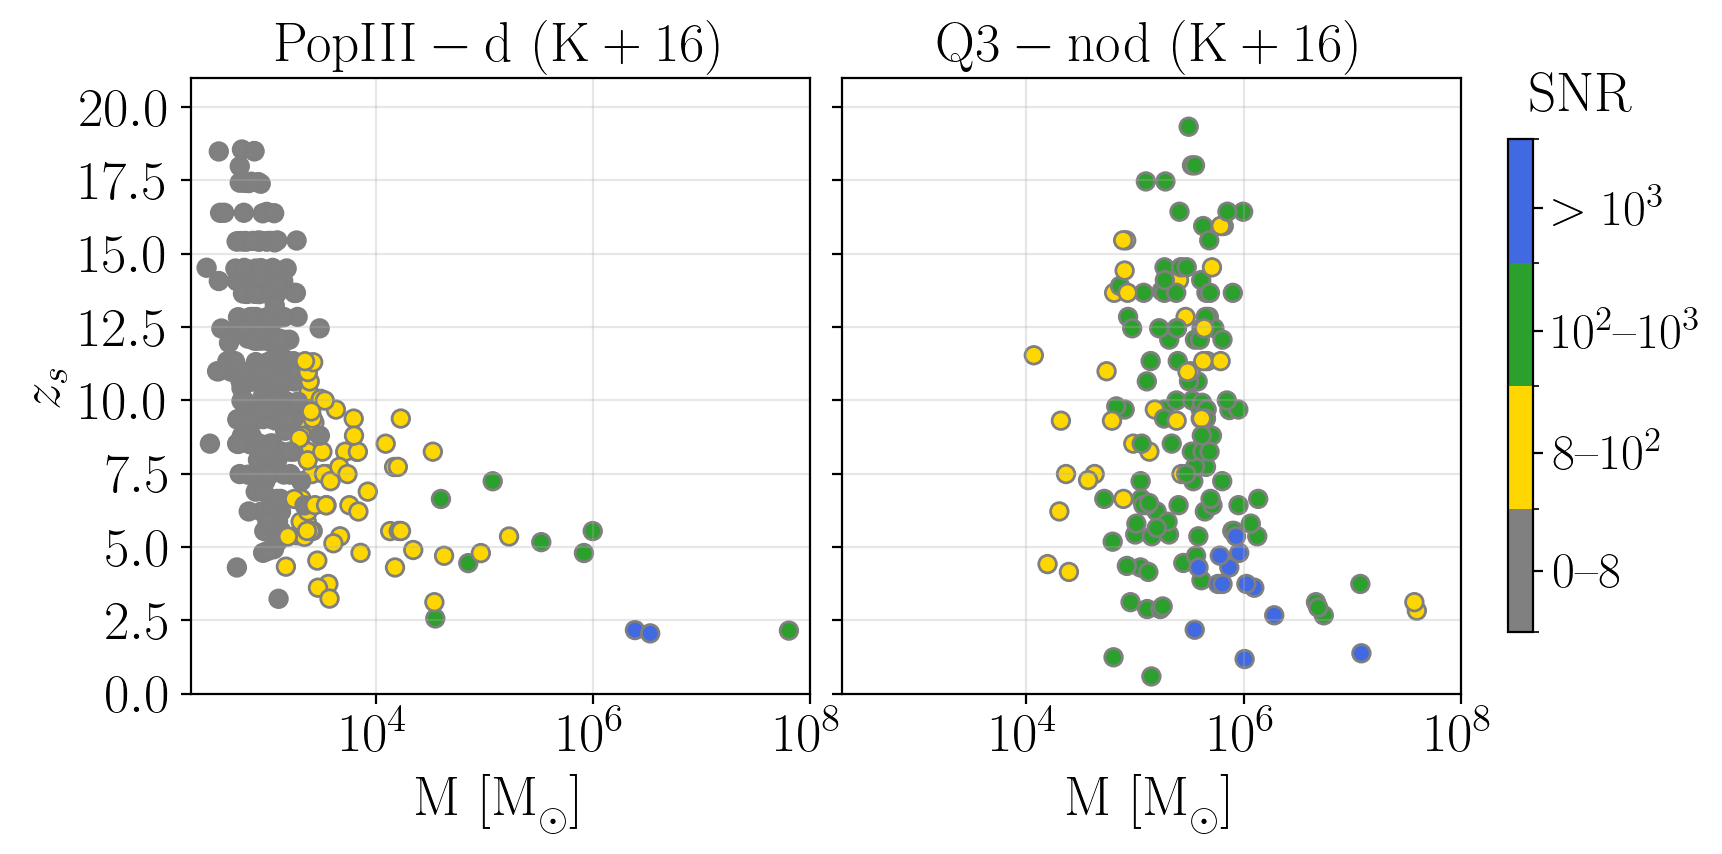

In [8]:
from matplotlib.colors import BoundaryNorm, ListedColormap

df1 = pd.read_csv("github/PopIIId/PopIIId_SNRLb_final.csv")
df2 = pd.read_csv("github/Q3nod/Q3nod_SNRLb_final.csv")

n1 = 1410 / 4
n2 = 657 / 4

df1_sample = df1.sample(n=int(n1), random_state=1)
df2_sample = df2.sample(n=int(n2), random_state=1)

bounds = [0, 8, 100,1000,  10000]
colors = ['grey', 'gold','tab:green', 'royalblue']
cmap = ListedColormap(colors)
norm = BoundaryNorm(bounds, cmap.N)


fig, axs = plt.subplots(1, 2, figsize=(10, 4), sharex=False, sharey=True)

sc0a = axs[0].scatter(
    df1_sample['m1'] + df1_sample['m2'],
    df1_sample['z_merger'],
    c=df1_sample['Mean_SNR'],
    cmap=cmap,
    norm=norm,
    edgecolors= 'tab:grey',
    s=40
)
axs[0].set_xscale("log")
axs[0].set_title(r'$\mathrm{PopIII-d\ (K+16)}$', fontsize = 20)
axs[0].set_xlabel(r"$\mathrm{M\ [M}_\odot]$", fontsize = 20)
axs[0].set_ylabel(r"$z_s$", fontsize = 20)
axs[0].grid(alpha=0.3)

axs[1].scatter(
    df2_sample['m1'] + df2_sample['m2'],
    df2_sample['z_merger'],
    c=df2_sample['Mean_SNR'],
    cmap=cmap,
    norm=norm,
    edgecolors= 'tab:grey',
    s=40
)

axs[1].set_xscale("log")
axs[1].set_title(r'$\mathrm{Q3-nod\ (K+16)}$', fontsize = 20)
axs[1].set_xlabel(r"$\mathrm{M\ [M}_\odot]$", fontsize = 20)
axs[1].grid(alpha=0.3)

cbar = fig.colorbar(sc0a, ax=axs, orientation='vertical', pad=4, shrink=0.8)
cbar.ax.set_title(r"$\mathrm{SNR}$", fontsize=20, pad=10, x = 3) 
cbar.set_ticks([4, 50, 500, 5000])  
cbar.set_ticklabels(['$0–8$', '$8–10^2$', '$10^2–10^3$', '$>10^3$'])
cbar.ax.tick_params(labelsize=18)

plt.subplots_adjust(wspace=0.051, right=0.76)  

for ax in axs:
    ax.set_xlim(2e2, 1e8)
    ax.set_ylim(0, 21)
    ax.set_yticks(np.arange(0, 21, 2.5))
    ax.tick_params(labelsize=20)

plt.savefig("github/Images/scatterSNR_popIII_Q3nod.pdf" , dpi=300, bbox_inches="tight")
plt.show()